# Dec 27th, 2022 (AD: full brn, FC cos dist, run)

**Motivation**: visualize differences in functional connectivity using cosine distance (focus on run level) <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def decode_key(k):
    ssr = k.split('_')
    if len(ssr) == 3:
        sub, ses, run = ssr
    elif len(ssr) == 2:
        sub, ses = ssr
        run = None
    elif len(ssr) == 1:
        sub = ssr[-1]
        ses = None
        run = None
    if ses is not None:
        ses = int(ses.split('-')[-1])
    if run is not None:
        run = int(run.split('-')[-1])
    sub = sub.split('-')[-1]
    g = re.findall(f"[a-zA-Z]+", sub).pop()
    try:
        s = int(re.findall(f"[^a-zA-Z]+", sub).pop())
    except IndexError:
        s = None
    return g, s, ses, run

def good_nodes_in_adj(a):
    nan = np.isnan(a).sum(0) == len(a)
    zero = np.nanmean(np.abs(a), 0) == 0
    good = np.logical_and(~nan, ~zero)
    return good

In [3]:
mice = Mice(128, load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))

template, _ = mice.al.mcc.get_template_volume()
template = template.astype('uint32')
root = mice.al.get_masks('root')
brn = mice.parcel['brain'][:]

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## Load

### Node2id (was: Node2Region)

In [4]:
n2i = np.load(pjoin(tmp_dir, 'AD_n2i.npy'), allow_pickle=True).item()
i2n = {i: n for n, i in n2i.items()}

n2l = {}
for n, i in n2i.items():
    info = mice.parcel.get(i)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

### Adjacency matrices

In [5]:
adj = np.load(pjoin(tmp_dir, 'AD_adj.npy'), allow_pickle=True).item()
len(adj), 348 + 118 + 69 + 2

(537, 537)

## Run level

In [6]:
a = collections.defaultdict(list)
for k, x in adj.items():
    group, sub, ses, run = decode_key(k)
    if not ses:
        continue
    a[f"{group}-{ses}"].append(np.expand_dims(x, 0))
print({k: len(x) for k, x in a.items()})
a = {
    k: np.nanmean(np.concatenate(x), 0)
    for k, x in a.items()
}

{
    'DKI-1': 60,
    'DKI-2': 48,
    'DKI-3': 43,
    'DKI-5': 78,
    'DKI-6': 70,
    'WT-1': 40,
    'WT-2': 40,
    'WT-3': 35,
    'WT-5': 32,
    'WT-6': 20
}

### Cosine sim

In [7]:
dist = {}
for ses in [1, 2, 3]:
    d = np_nans(len(n2i))
    g1 = good_nodes_in_adj(a[f"DKI-{ses}"])
    g2 = good_nodes_in_adj(a[f"WT-{ses}"])
    good = np.logical_and(g1, g2)    
    for n in np.where(good)[0]:
        u = a[f"DKI-{ses}"][n]
        v = a[f"WT-{ses}"][n]
        d[n] = sp_dist.cosine(u, v) / 2
    dist[ses] = d

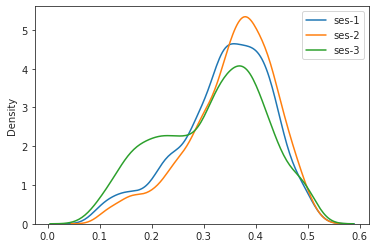

In [8]:
for ses, d in dist.items():
    sns.kdeplot(d, color=f"C{ses-1}", label=f'ses-{ses}')
plt.legend()
plt.show()

In [9]:
delta = {
    ses: np_nans(brn.shape)
    for ses in dist
}
for n, i in n2i.items():
    _m = brn == i
    for ses, d in dist.items():
        delta[ses][_m] = d[n]

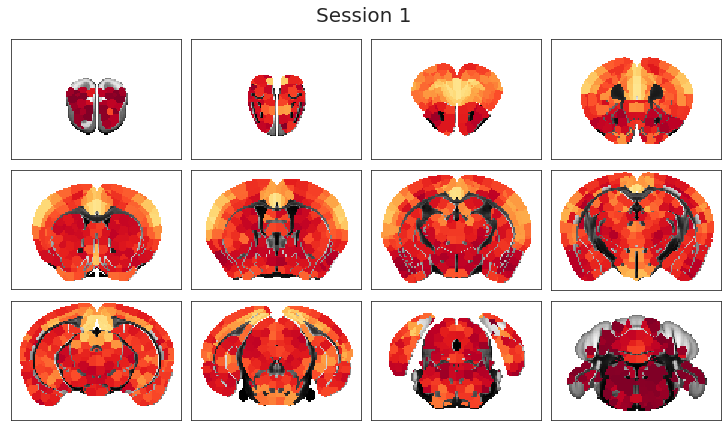

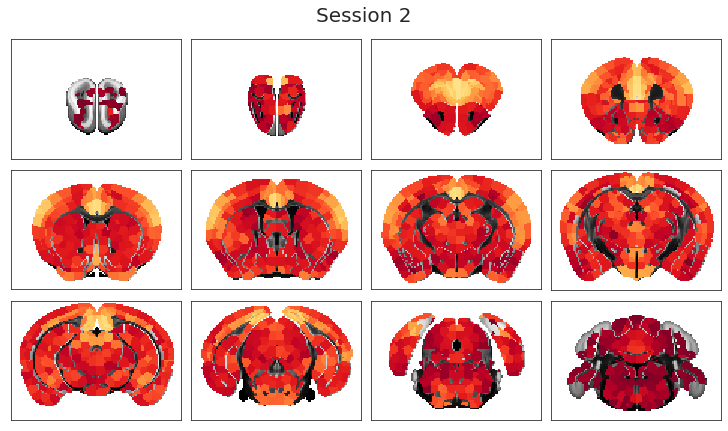

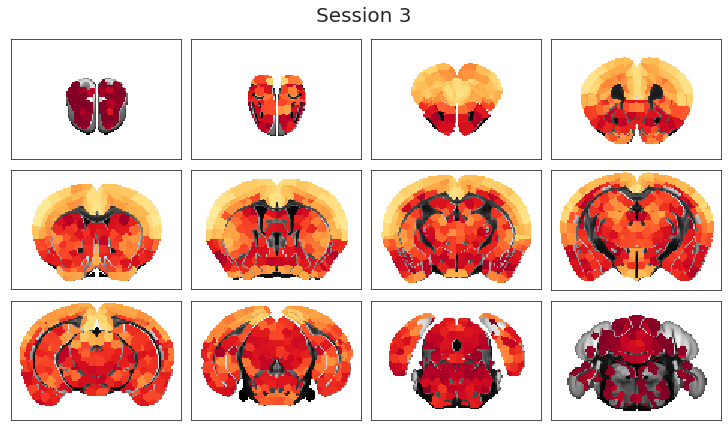

In [10]:
slices = range(10, 111, 9)
for ses, x in delta.items():
    fig, axes = create_figure(3, 4, (10, 5.45), 'all', 'all', constrained_layout=True)
    for i, s_ in enumerate(slices):
        ax = axes.flat[i]
        ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
        ax.imshow(x[s_], cmap='YlOrRd', vmin=0.0, vmax=0.5)
    fig.suptitle(f"Session {ses}", fontsize=20, y=1.07)
    remove_ticks(axes, False)
    plt.show()
    print('\n\n')

In [11]:
d_all = np.concatenate([
    np.expand_dims(x, 0) for
    x in dist.values()
])
d_all.shape

(3, 2368)

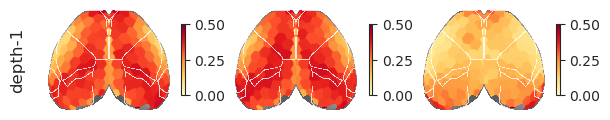

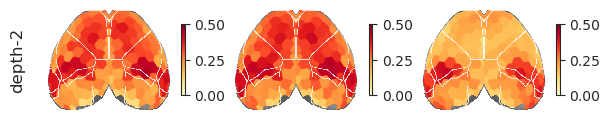

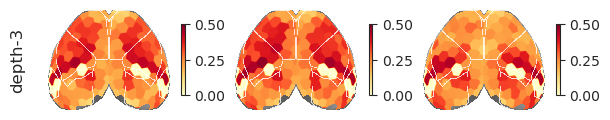

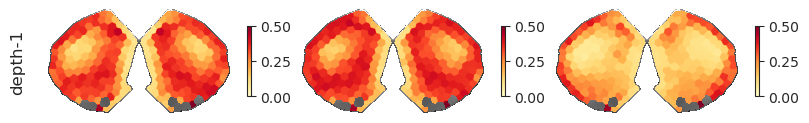

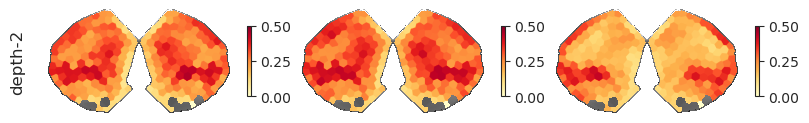

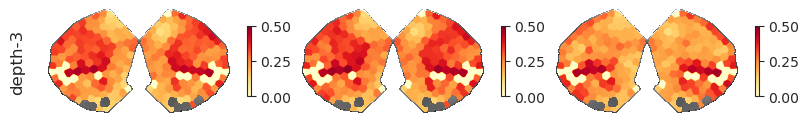

In [12]:
kwargs = {
    'vmin': 0.0,
    'vmax': 0.5,
    'cbar': True,
    'cmap': 'YlOrRd',
    'cbar_pad': 0.1,
    'cbar_shrink': 0.5,
    'constrained': True,
}
for i in range(3):
    _ = bs.show(
        data={f'depth-{i + 1}\n': d_all},
        layer=i,
        proj='top',
        contour=True,
        figsize=(6, 1.5),
        **kwargs,
    )
for i in range(3):
    _ = bs.show(
        data={f'depth-{i + 1}\n': d_all},
        layer=i,
        proj='flat',
        contour=False,
        figsize=(8, 1.5),
        **kwargs,
    )

In [13]:
df_brn = []
for ses, d in dist.items():
    for n, i in n2i.items():
        info = mice.parcel(i)
        info['ses'] = ses
        info['d'] = d[n]
        df_brn.append({
            k: [v] for k, v in info.items()
            if k not in ['id', 'region']
        })
df_brn = pd.DataFrame(merge_dicts(df_brn))

In [14]:
meanprops = {
    'marker': 'o',
    'markerfacecolor': 'snow',
    'markeredgecolor': 'k',
    'markersize': 6,
    'alpha': 1.0,
}
props_box = {
    'y': 'd',
    'hue': 'ses',
    'showmeans': True,
    'meanprops': meanprops,
    'width': 0.7,
}

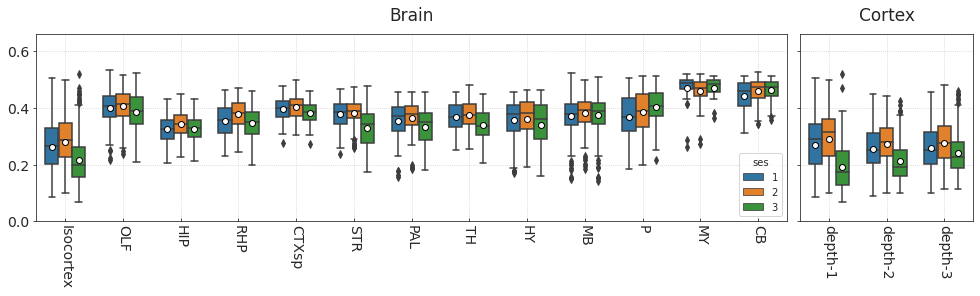

In [15]:
fig, axes = create_figure(1, 2, (13.5, 4), sharey='all', width_ratios=[13/3, 1], constrained_layout=True)
sns.boxplot(
    data=df_brn,
    x='acro',
    ax=axes[0],
    **props_box,
)
sns.boxplot(
    data=df_brn.loc[df_brn['acro'] == 'Isocortex'],
    x='layer',
    ax=axes[1],
    **props_box,
)
axes[1].set_xticklabels([
    f"depth-{i + 1}"
    for i in range(3)
])
axes[0].set_title(f"Brain", fontsize=17, y=1.04)
axes[1].set_title(f"Cortex", fontsize=17, y=1.04)
axes[1].get_legend().remove()
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', rotation=-90, direction='in')
    ax.set(xlabel='', ylabel='', ylim=(0, 0.66))
    ax.grid()
plt.show()

In [16]:
df_ctx = []
for ses, d in dist.items():
    for n, i in n2i.items():
        info = mice.parcel.get(i)
        if info['acro'] != 'Isocortex':
            continue
        info['ses'] = ses
        info['affil'] = bs.affil['regions_affil_max'][info['region']]
        info['d'] = d[n]
        df_ctx.append({
            k: [v] for k, v in info.items()
            if k not in ['id', 'region']
        })
df_ctx = pd.DataFrame(merge_dicts(df_ctx))

In [17]:
props_box = {
    'x': 'affil',
    'y': 'd',
    'hue': 'ses',
    'order': bs.affil['colors'],
    # 'palette': bs.affil['colors'],
    'boxprops': {
        'edgecolor': 'k',
        #'facecolor': 'none',
        'alpha': None,
        'lw': 1.5,
        'ls': '-'},
    'medianprops': {'color': 'k', 'alpha': 1.0, 'lw': 1.5},
    'whiskerprops': {'color': 'k', 'alpha': 1.0, 'lw': 1.5},
    'capprops': {'color': 'k', 'lw': 1.5, 'alpha': 1.0, 'zorder': 3},
    # 'flierprops': {'alpha': 0.0, 'zorder': 1},
    'meanprops': meanprops,
    'showfliers': True,
    'showmeans': True,
    'saturation': 0.75,
    'width': 0.6,
    'whis': np.inf,
}

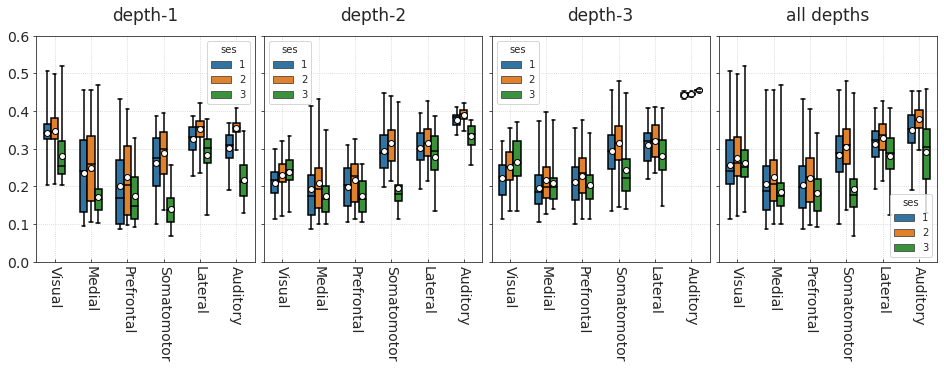

In [18]:
fig, axes = create_figure(1, 4, (13, 5), sharey='all', constrained_layout=True)
for i in range(3):
    sns.boxplot(
        data=df_ctx.loc[df_ctx['layer'] == i],
        ax=axes[i],
        **props_box,
    )
    axes[i].set_title(f"depth-{i + 1}", fontsize=17, y=1.04)
sns.boxplot(
    data=df_ctx,
    ax=axes[-1],
    **props_box,
)
axes[-1].set_title(f"all depths", fontsize=17, y=1.04)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=14)
    ax.tick_params(axis='x', rotation=-90, direction='in')
    ax.set(xlabel='', ylabel='', ylim=(0, 0.6))
    ax.grid()
    for e in ax.get_children():
        if isinstance(e, PathPatch):
            fc = e.get_facecolor()
            fc = (*fc[:-1], 1.0)
            e.set_facecolor(fc)
plt.show()

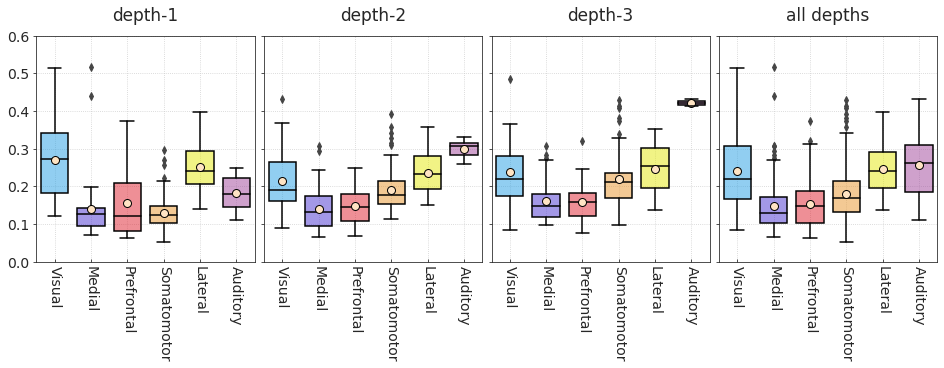

In [21]:
# was all sessions together

In [19]:
src = ['Isocortex', 'MO', 'SS', 'SSp']
structs = []
for i in mice.al.get(src)['id']:
    tree, base_lvl = mice.al.get_subtree(
        base_id=i,
        n_levels=2,
        show=False,
    )
    nodes = []
    for n in tree.nodes:
        if tree.level(n) == 1:
            nodes.append(n)
    nodes = mice.al(nodes)['acronym']
    structs.extend(nodes.values.tolist())
structs = [e for e in structs if e not in src]
masks = mice.al.get_masks(structs)
len(masks)

25

In [20]:
id2area = {}
for i in mice.parcel.df.loc[
    (mice.parcel.df['acro'] == 'Isocortex') &
    (mice.parcel.df['hemis'] == 1), 'id'].unique():
    info = mice.parcel(i)
    max_match = np.argmax([
        overlap_score(m, brn == i)
        for k, m in masks.items()
    ])
    area = list(masks)[max_match]
    id2area[i] = area
    id2area[i + mice.parcel.num_ctx_rois() // 2] = area
id2area = dict(sorted(id2area.items()))

In [21]:
df_area = []
for ses, d in dist.items():
    for i, n in i2n.items():
        if i not in id2area:
            continue
        info = {
            'area': id2area[i],
            **mice.parcel(i),
            'ses': ses,
            'd': d[n],
        }
        df_area.append({
            k: [v] for k, v in info.items()
            if k not in ['id', 'region', 'acro']
        })
df_area = pd.DataFrame(merge_dicts(df_area))

In [22]:
props_box = {
    'x': 'area',
    'y': 'd',
    'hue': 'ses',
    'order': df_area['area'].unique(),
    'meanprops': meanprops,
    'showmeans': True,
    'width': 0.7,
}

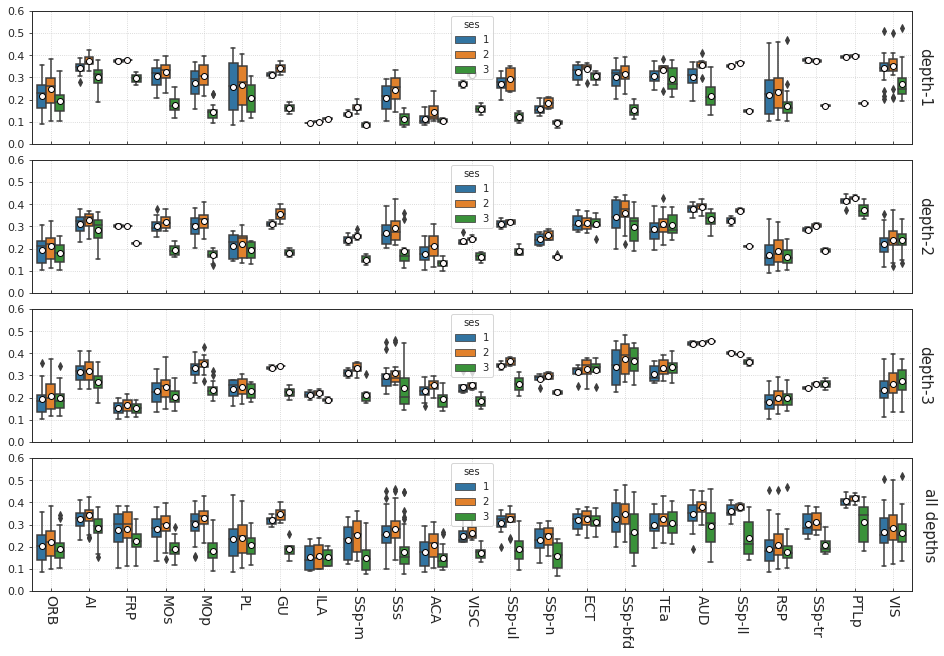

In [23]:
fig, axes = create_figure(4, 1, (13, 9), 'all', 'all', constrained_layout=True)

for i in range(3):
    ax = axes[i]
    sns.boxplot(data=df_area.loc[df_area['layer'] == i], ax=ax, **props_box)
    axtw = ax.twinx()
    axtw.set_ylabel(f"depth-{i + 1}", rotation=-90, fontsize=15, labelpad=20)
    axtw.set_yticks([])
    
ax = axes[-1]
sns.boxplot(data=df_area, ax=ax, **props_box)
axtw = ax.twinx()
axtw.set_ylabel('all depths', rotation=-90, fontsize=15, labelpad=25)
axtw.set_yticks([])
    
for ax in axes.flat:
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=14, rotation=-90, direction='in')
    ax.set(xlabel='', ylabel='', ylim=(0, 0.6))
    ax.grid()

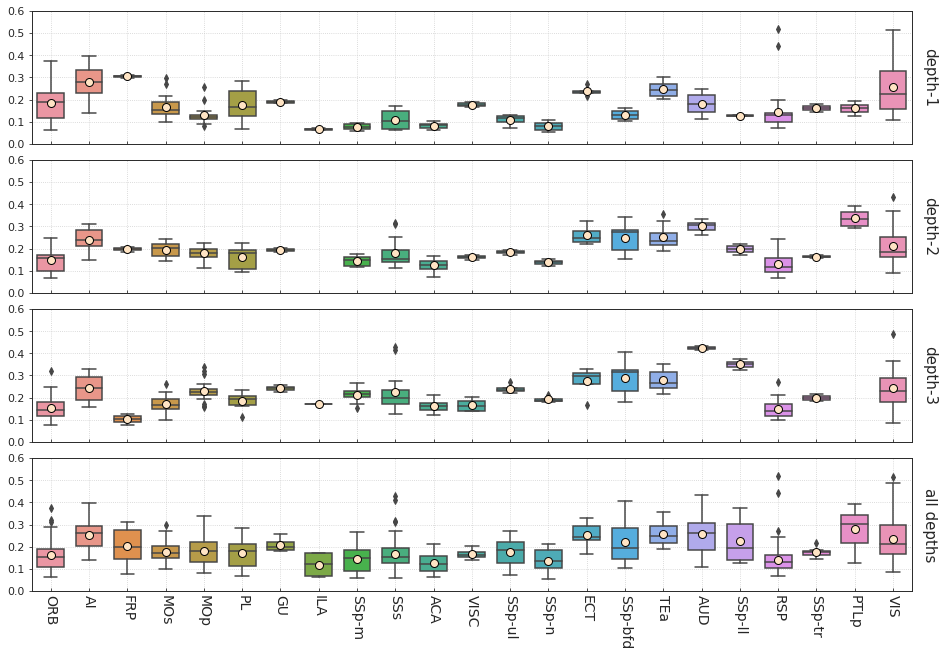

In [81]:
# was all sessions together